# 📖 Import Library 

In [86]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV  # For splitting data into training and testing sets
from sklearn.preprocessing import StandardScaler  # For scaling numerical features
from xgboost import XGBClassifier  # The random XG Boost model
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score  # For model evaluation

from xgboost import plot_importance
from imblearn.over_sampling import SMOTE

# 💻 Load in data

In [4]:
df=pd.read_csv('../datasets/poker_completed.csv')

In [5]:
df.shape

(8863, 33)

In [88]:
# Run model to check accuracy before apply grid search
# Set up X,y
X = df[['round_label', 'pot', 'player_stack',
        'poker_hand', 'card1_rank', 'card2_rank','card1_suit','card2_suit', 'community1_rank', 
        'community2_rank', 'community3_rank', 'community4_rank', 
        'community5_rank','community1_suit', 'community2_suit', 'community3_suit', 
        'community4_suit', 'community5_suit']]

y = df['action_label']  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# Train XGBoost Classifier
xgb_clf = XGBClassifier(n_estimators=100, random_state=42)
xgb_clf.fit(X_train_sc, y_train)  # Use scaled features for training
y_pred = xgb_clf.predict(X_test_sc)  # Use scaled features for prediction

# Display results
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


XGBoost Accuracy: 0.5815002820078963
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.59      0.57       622
           1       0.65      0.66      0.65       737
           2       0.51      0.43      0.47       414

    accuracy                           0.58      1773
   macro avg       0.57      0.56      0.56      1773
weighted avg       0.58      0.58      0.58      1773



In [71]:
# Check baseline 
y.value_counts(normalize=True)

action_label
1    0.388807
0    0.363647
2    0.247546
Name: proportion, dtype: float64

In [90]:
# Check training and testing scores
print(xgb_clf.score(X_train_sc, y_train))  # Training accuracy
print(xgb_clf.score(X_test_sc, y_test))    # Testing accuracy

# The result is OVERFITTING

0.8860366713681241
0.5815002820078963


In [44]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_sc, y_train)

# Updated parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.05, 0.1],
    'gamma': [0, 1, 5],  # Regularization parameter
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(n_estimators=500, random_state=42, eval_metric='mlogloss'),
    param_grid=param_grid,
    scoring='balanced_accuracy',  # Balanced scoring metric
    cv=3,
    verbose=1
)

# Fit grid search on the balanced data
grid_search.fit(X_train_bal, y_train_bal)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train the best model
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test_sc)

# Results
print("Improved Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best Parameters: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.6}
Improved Balanced Accuracy: 0.5659566867482969
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.51      0.54       622
           1       0.67      0.62      0.64       737
           2       0.43      0.57      0.49       414

    accuracy                           0.57      1773
   macro avg       0.56      0.57      0.56      1773
weighted avg       0.58      0.57      0.57      1773



In [92]:
# Run model by applyting the best_param
# Apply with the best_params
# Best Parameters: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.6}

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sc, y_train)

# Train XGBoost
xgb_clf = XGBClassifier(n_estimators=200, 
                        gamma = 1,
                        colsample_bytree=1.0, 
                        learning_rate=0.01, 
                        max_depth=7, 
                        min_child_weight=1, 
                        subsample=0.6, 
                        random_state=42)

xgb_clf.fit(X_train_res, y_train_res)
y_pred = xgb_clf.predict(X_test_sc)

# Display results
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))

XGBoost Accuracy: 0.565707839819515
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.45      0.51       622
           1       0.68      0.62      0.65       737
           2       0.43      0.65      0.52       414

    accuracy                           0.57      1773
   macro avg       0.56      0.57      0.56      1773
weighted avg       0.59      0.57      0.57      1773



In [94]:
# Check training and testing scores
print(xgb_clf.score(X_train_sc, y_train))  # Training accuracy
print(xgb_clf.score(X_test_sc, y_test))    # Testing accuracy

# The result is better compared to earlier attempt BUT still overfitting

0.6497884344146685
0.565707839819515


## 📝 How well XG Boost can predict the hand?

1. **Overall Accuracy:** The XGBoost model, before applying the best parameters, achieves an accuracy of **58%**. After applying the best parameters, the accuracy changes to **57%**. Although the accuracy is slightly lower after applying the best parameters, the model performs better in terms of handling overfitting.

    This is a _notable improvement_ compared to the Logistic Regression model **(42%)** and the Neural Network model **(47%)**. 
    

2. **Performance Metrics for Each Class::**
     **Class 0 (Call)**
   - **Precision (0.59):** When the model predicts "Call," 59% of those predictions are correct.
   - **Recall (0.45):** The model identifies 45% of the actual "Call" instances correctly.
   - **F1-score (0.51):** The harmonic mean of precision and recall shows moderate performance for this class, with room for improvement.
</br></br>
    **Class 1 (Raise)**
   - **Precision (0.68):** When the model predicts "Raise," 68% of those predictions are correct.
   - **Recall (0.62):** The model identifies 62% of the actual "Raise" instances correctly.
   - **F1-score (0.65):** The model performs relatively well for this class, compared to others.
    </br></br>
    **Class 2 (Fold)**
   - **Precision (0.43):** When the model predicts "Fold," only 43% of those predictions are correct.
   - **Recall (0.65):** The model identifies 65% of the actual "Fold" instances correctly.
   - **F1-score (0.52):** The model is less precise for this class but detects a higher percentage of actual instances.
</br></br>
3. **Key Observations** </br>
    **Strengths:**
   - The model performs best for predicting "Raise" (Class 1), achieving the highest precision (0.68) and F1-score (0.65).
   - It has a good recall for "Fold" (Class 2) at 65%, suggesting it captures many true instances of this class.

    **Weaknesses:**
   - Precision for "Fold" (Class 2) is low (0.43), meaning the model struggles to avoid false positives for this action.
   - The recall for "Call" (Class 0) is the weakest (0.45), indicating many true "Call" instances are misclassified.

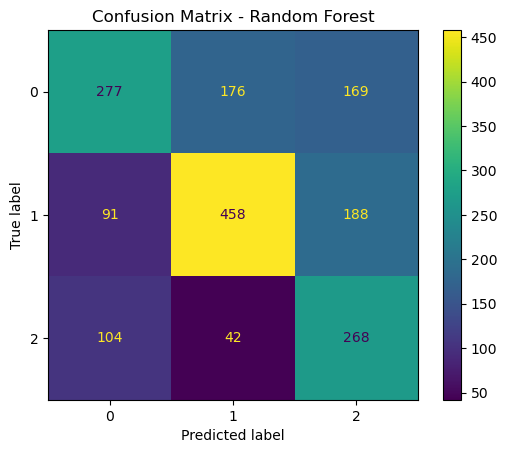

In [58]:
# Compute the confusion matrix
# 0 = call , 1 = raise, 3 = fold

cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
disp.plot(cmap='viridis', values_format='d')

# Add a title for clarity
plt.title("Confusion Matrix - Random Forest")
plt.show()

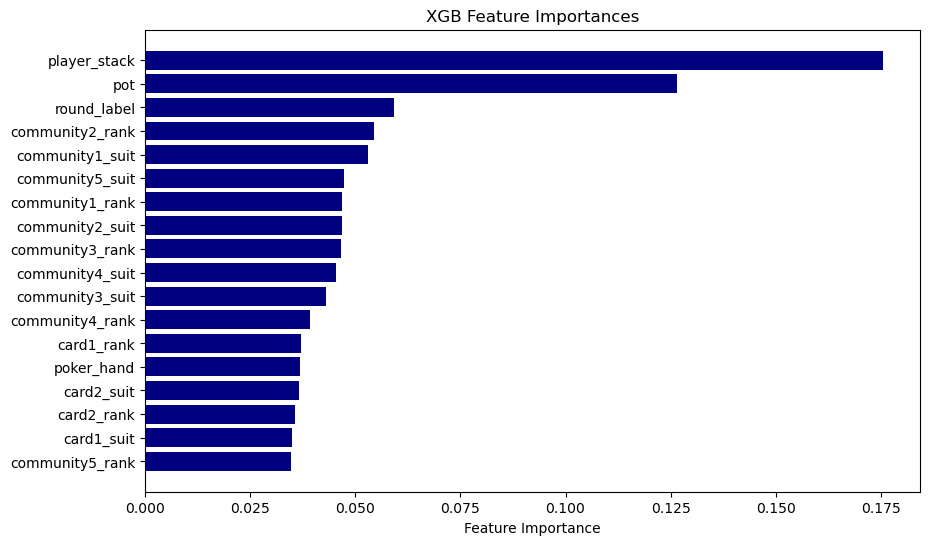

In [79]:
# Plot Feature Importances
importance_df = pd.DataFrame({
    'Feature': X.columns, 
    'Importance': xgb_clf.feature_importances_}).sort_values(by='Importance')

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='navy')
plt.xlabel('Feature Importance')
plt.title('XGB Feature Importances')
plt.savefig('../images/XBG_Feature_Importances.png', dpi=300)
plt.show()

In [81]:
importance_df.round(2)

,Feature,Importance
12,community5_rank,0.03
6,card1_suit,0.04
5,card2_rank,0.04
7,card2_suit,0.04
3,poker_hand,0.04
4,card1_rank,0.04
11,community4_rank,0.04
15,community3_suit,0.04
16,community4_suit,0.05
10,community3_rank,0.05


## 📝 How the feature importance playing a role in the XG Boost model?
#### The feature importance help indicating how each feature influences the target variable (`action_label`).

#### Most Influential Features:
- **`pot` (0.18) and `player_stack` (0.13)**: Impact decisions but less significantly.

#### Moderate Importance:
  - Card suit and ranks contribute moderately to the predictions.

In [96]:
import joblib

# Save the model
joblib.dump(xgb_clf, '../model/poker_strategy_XG.pkl')

['../model/poker_strategy_XG.pkl']

In [84]:
X.dtypes

round_label        int64
pot                int64
player_stack       int64
poker_hand         int64
card1_rank         int64
card2_rank         int64
card1_suit         int64
card2_suit         int64
community1_rank    int64
community2_rank    int64
community3_rank    int64
community4_rank    int64
community5_rank    int64
community1_suit    int64
community2_suit    int64
community3_suit    int64
community4_suit    int64
community5_suit    int64
dtype: object

In [100]:
X.shape

(8863, 18)